In [3]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Datos

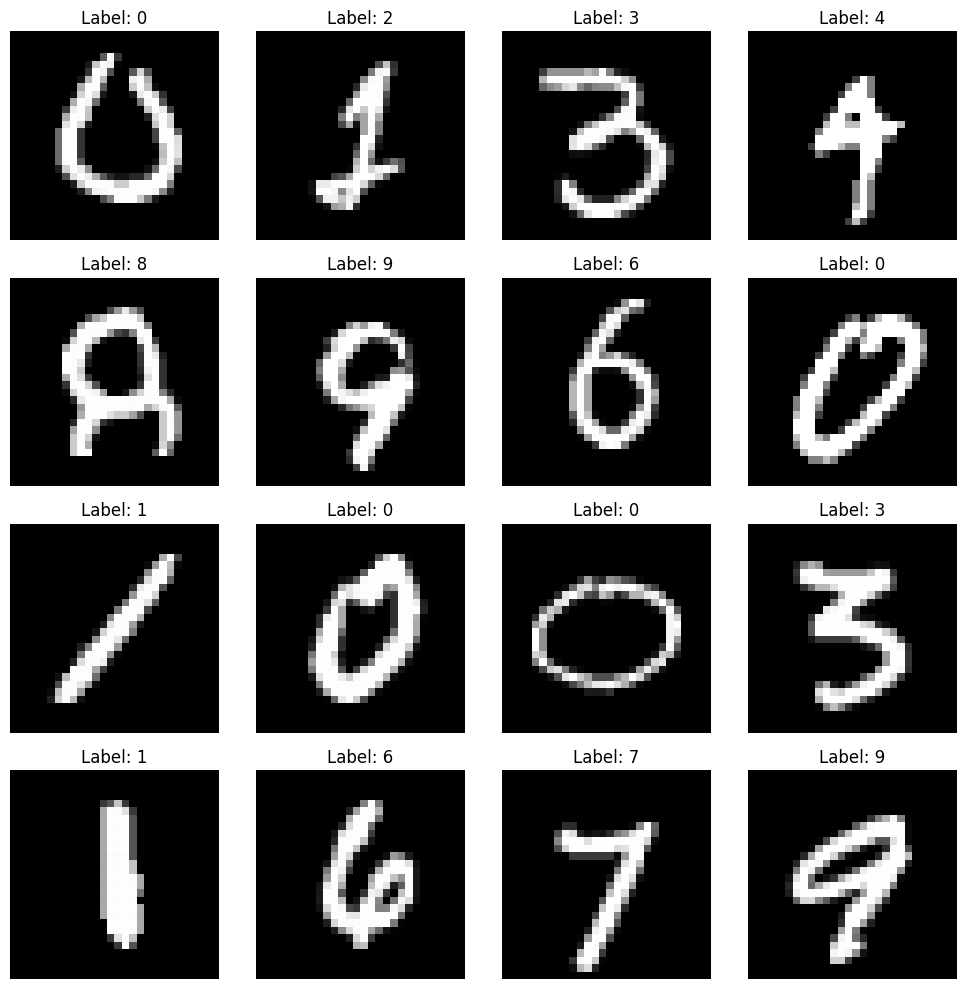

In [4]:

# Load MNIST dataset
# Definimos una secuencia de transformaciones para aplicar a las imágenes del dataset.
# En este caso, solo convertimos las imágenes a tensores utilizando `ToTensor()`.
# Esto es necesario para que las imágenes estén en un formato compatible con PyTorch.
transform = transforms.Compose([
    transforms.ToTensor()  # Convierte la imagen de un formato PIL o numpy.ndarray a un tensor.
])

# Cargamos el dataset MNIST de entrenamiento.
# `root='./data'` especifica el directorio donde se descargarán los datos si no están presentes.
# `train=True` indica que queremos el conjunto de datos de entrenamiento.
# `transform=transform` aplica las transformaciones definidas previamente a cada imagen.
# `download=True` descarga los datos si no están disponibles en el directorio especificado.
mnist_dataset = datasets.MNIST(
    root='./data', train=True, transform=transform, download=True
)

# Creamos un DataLoader que nos permite cargar los datos en lotes pequeños.
# `dataset=mnist_dataset` es el dataset que se cargará.
# `batch_size=16` indica que cada lote contendrá 16 imágenes y etiquetas.
# `shuffle=True` mezcla los datos aleatoriamente en cada época, mejorando la generalización del modelo.
data_loader = DataLoader(
    mnist_dataset, batch_size=16, shuffle=True
)

# Obtenemos un único lote de datos del DataLoader.
# `next(iter(data_loader))` convierte el DataLoader en un iterador y toma el primer lote.
# El lote contiene `images` (los tensores de las imágenes) y `labels` (las etiquetas correspondientes).
images, labels = next(iter(data_loader))


# Plot the images in a grid
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f'Label: {labels[i].item()}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Arquitectura

In [5]:

# Definimos el modelo MLP
# MLP hereda de nn.Module, lo que permite utilizar las funciones y propiedades de PyTorch
# para crear, entrenar y evaluar redes neuronales.
class MLP(nn.Module):
    def __init__(self):
        # Inicializamos la clase base nn.Module
        # Esto habilita funciones esenciales como la gestión de capas y forward pass.
        super(MLP, self).__init__()
        # Capa completamente conectada: de entrada (28x28 píxeles) a 512 neuronas
        self.fc1 = nn.Linear(28 * 28, 256)
        # Capa oculta: de 512 neuronas a 256 neuronas
        self.fc2 = nn.Linear(256, 128)
        # Capa de salida: de 256 neuronas a 10 clases (números del 0 al 9)
        self.fc3 = nn.Linear(128, 10)
        
        #self.fc4 = nn.Linear(10, 10)
        # Función de activación ReLU
        self.relu = nn.ReLU()
        # Dropout para evitar sobreajuste
        self.dropout = nn.Dropout(0.2)

    # Definimos cómo pasa la información a través de la red
    # Este método es obligatorio en las clases que heredan de nn.Module.
    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Aplanamos las imágenes (de 28x28 a 1D)
        x = self.relu(self.fc1(x))  # Aplicamos la primera capa y ReLU
        x = self.dropout(x)         # Aplicamos Dropout
        x = self.relu(self.fc2(x))  # Aplicamos la segunda capa y ReLU
        x = self.dropout(x)         # Aplicamos Dropout
        x = self.fc3(x)             # Aplicamos la capa de salida
        return x

# Entrenamiento

In [6]:
# Hiperparámetros
batch_size = 64       # Tamaño de lote
learning_rate = 0.001 # Tasa de aprendizaje
epochs = 10           # Número de épocas de entrenamiento

# Preprocesamiento y carga de datos de MNIST
transform = transforms.Compose([
    transforms.ToTensor(),                 # Convertimos imágenes a tensores
    transforms.Normalize((0.5,), (0.5,))  # Normalizamos a media 0 y varianza 1
])
train_dataset = datasets.MNIST(
    root='./data', train=True, transform=transform, download=True)  # Dataset de entrenamiento
test_dataset = datasets.MNIST(
    root='./data', train=False, transform=transform, download=True)  # Dataset de prueba
train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True)  # Dataloader para entrenamiento
test_loader = DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False)  # Dataloader para prueba

# Definimos el modelo, la función de pérdida y el optimizador
model = MLP()                             # Creamos una instancia del modelo MLP
criterion = nn.CrossEntropyLoss()         # Función de pérdida para clasificación
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Optimizador Adam

# Bucle de entrenamiento
for epoch in range(epochs):
    model.train()  # Ponemos el modelo en modo entrenamiento
    for images, labels in train_loader:  # Iteramos sobre lotes de datos
        optimizer.zero_grad()            # Reiniciamos los gradientes
        outputs = model(images)          # Hacemos una predicción con el modelo
        loss = criterion(outputs, labels)  # Calculamos la pérdida
        loss.backward()                  # Propagamos los gradientes
        optimizer.step()                 # Actualizamos los pesos del modelo

    # Mostramos la pérdida al final de cada época
    print(f"Época [{epoch+1}/{epochs}], Pérdida: {loss.item():.4f}")



Época [1/10], Pérdida: 0.1670
Época [2/10], Pérdida: 0.1589
Época [3/10], Pérdida: 0.2436
Época [4/10], Pérdida: 0.0605
Época [5/10], Pérdida: 0.3473
Época [6/10], Pérdida: 0.2582
Época [7/10], Pérdida: 0.0085
Época [8/10], Pérdida: 0.0305
Época [9/10], Pérdida: 0.0804
Época [10/10], Pérdida: 0.0606


# Evaluación del modelo

In [7]:
model.eval()  # Ponemos el modelo en modo evaluación (desactiva Dropout)
correct = 0
total = 0
with torch.no_grad():  # Desactivamos el cálculo de gradientes para evaluación
    for images, labels in test_loader:  # Iteramos sobre los datos de prueba
        outputs = model(images)         # Hacemos predicciones
        _, predicted = torch.max(outputs.data, 1)  # Obtenemos la clase con mayor probabilidad
        total += labels.size(0)         # Total de muestras evaluadas
        correct += (predicted == labels).sum().item()  # Contamos las predicciones correctas

# Calculamos y mostramos la precisión del modelo
accuracy = 100 * correct / total
print(f"Accuracy en el conjunto de prueba: {accuracy:.2f}%")

Accuracy en el conjunto de prueba: 97.76%


________________
-PREGUNTA 2.1.1

(PERCEPTRON MULTICAPA) MODIFICACIONES EN LA ARQUITECTURA

    El profesor indicó variar solo un parámetro de los indicados en el enunciado.

RESPUESTA:

    Elegí modificar el número de neuronas por capa. En primera instancia, ejecuté la simulación con la configuración original:
        -Configuración inicial:
        28x28 a 512 
        512 a 256
        256 a 10
    Luego, ejecuté la simulación reduciendo el número de neuronas por capa:
        -Configuración modificada:
        28x28 a 256
        256 a 128
        128 a 10
    Respecto a la configuración inicial, se obtuvo un Accuracy de 97.71% y una Pérdida final de 0.3409. Mientras que, con la reducción de neuronas obtuvimos un Accuracy de 97.63% y una Pérdida final de 0.2091. Esto puede indicar que mediante la configuración inicial se tenía un sobreajuste el cual fue mejorado mediante la reducción de neuronas. 

Aqui copio los resultados de la simulación:

-Configuración inicial:
Accuracy en el conjunto de prueba: 97.71%

Época [1/10], Pérdida: 0.2059

Época [2/10], Pérdida: 0.0869

Época [3/10], Pérdida: 0.2697

Época [4/10], Pérdida: 0.0565

Época [5/10], Pérdida: 0.0207

Época [6/10], Pérdida: 0.0152

Época [7/10], Pérdida: 0.0440

Época [8/10], Pérdida: 0.0307

Época [9/10], Pérdida: 0.0755

Época [10/10], Pérdida: 0.3409

-Configuración mejorada:
Accuracy en el conjunto de prueba: 97.63%

Época [1/10], Pérdida: 0.1905

Época [2/10], Pérdida: 0.2809

Época [3/10], Pérdida: 0.0601

Época [4/10], Pérdida: 0.6275

Época [5/10], Pérdida: 0.0271

Época [6/10], Pérdida: 0.0351

Época [7/10], Pérdida: 0.0469

Época [8/10], Pérdida: 0.0619

Época [9/10], Pérdida: 0.0178

Época [10/10], Pérdida: 0.2091


______________________________________
-PREGUNTA 2.1.2

(PERCEPTRON MULTICAPA) MODIFICACIONES EN EL ENTRENAMIENTO:

    El profesor indicó variar solo un parámetro de los indicados en el enunciado.

RESPUESTA:

En esta pregunta opté por variar la Tasa de Aprendizaje. Al respecto, se probaron los valores de 0.01, 0.001 y 0.0001. Los resultados se muestran mas abajo. Ahora bien, es mas recomendable una Tasa de Aprendizaje de 0.001, debido a que se obtiene la precisión mas alta entre los valores sometidos a prueba. Asimismo, para esta Tasa de Aprendizaje observamos que la Pérdida disminuye de manera constante entre las épocas. Notemos que una Tasa de 0.01, provoca un comportamiento errático de la Pérdida, y la precisión case a 90.67%. Mientras que, la Tasa de 0.0001 es mas lenta de converger sin obtener una precisión mas elevada que cuando simulamos con la Tasa de 0.001. En ese sentido, es recomendable la Tasa de Aprendizaje de 0.001.


Para un learning_rate = 0.01 # Tasa de aprendizaje

90.67% de Accuracy

Época [1/10], Pérdida: 0.6149

Época [2/10], Pérdida: 0.6427

Época [3/10], Pérdida: 0.3958

Época [4/10], Pérdida: 0.7424

Época [5/10], Pérdida: 0.4870

Época [6/10], Pérdida: 0.3082

Época [7/10], Pérdida: 0.6939

Época [8/10], Pérdida: 0.4401

Época [9/10], Pérdida: 1.2409

Época [10/10], Pérdida: 0.2865


Para un learning_rate = 0.001 # Tasa de aprendizaje

97.63% de Accuracy

Época [1/10], Pérdida: 0.1905

Época [2/10], Pérdida: 0.2809

Época [3/10], Pérdida: 0.0601

Época [4/10], Pérdida: 0.6275

Época [5/10], Pérdida: 0.0271

Época [6/10], Pérdida: 0.0351

Época [7/10], Pérdida: 0.0469

Época [8/10], Pérdida: 0.0619

Época [9/10], Pérdida: 0.0178

Época [10/10], Pérdida: 0.2091


Para un learning_rate = 0.0001 # Tasa de aprendizaje

97.07% de Accuracy

Época [1/10], Pérdida: 0.4513

Época [2/10], Pérdida: 0.3692

Época [3/10], Pérdida: 0.0708

Época [4/10], Pérdida: 0.4734

Época [5/10], Pérdida: 0.3835

Época [6/10], Pérdida: 0.0805

Época [7/10], Pérdida: 0.0880

Época [8/10], Pérdida: 0.1680

Época [9/10], Pérdida: 0.0224

Época [10/10], Pérdida: 0.0565
_____________________________


In [8]:
# Verificar si hay una GPU disponible, de lo contrario usar la CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocesamiento: Definir transformaciones para los datos
transform = transforms.Compose([
    transforms.ToTensor(),                # Convertir imágenes a tensores
    transforms.Normalize((0.5,), (0.5,))  # Normalizar los valores a un rango de [-1, 1]
])

# Cargar el conjunto de datos MNIST
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)  # Datos de entrenamiento
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)  # Datos de prueba

# Crear DataLoaders para manejar los datos de forma eficiente
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)   # Loader para entrenamiento (batch de 128, mezclado)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)    # Loader para prueba (batch de 128, sin mezclar)

class CNN(nn.Module):
    def __init__(self, verbose=False, filters_l1=32, filters_l2=64, dropout=0.2, final_layer_size=128):
        super(CNN, self).__init__()
        self.verbose = verbose
        self.filters_l1 = filters_l1
        self.filters_l2 = filters_l2
        self.dropout_rate = dropout
        self.final_layer_size = final_layer_size

        # Primera capa convolucional
        self.conv1 = nn.Conv2d(1, self.filters_l1, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Segunda capa convolucional
        self.conv2 = nn.Conv2d(self.filters_l1, self.filters_l2, kernel_size=3, stride=1, padding=1)

        # Calcular automáticamente las dimensiones de la capa lineal (fc1)
        self.fc1_input_size = self._calculate_fc1_input_size()
        
        # Primera capa completamente conectada
        self.fc1 = nn.Linear(self.fc1_input_size, self.final_layer_size)
        self.dropout = nn.Dropout(self.dropout_rate)
        self.fc2 = nn.Linear(self.final_layer_size, 10)  # Capa de salida para 10 clases (MNIST)

    def _calculate_fc1_input_size(self):
        """
        Calcula automáticamente el tamaño de la entrada para la primera capa completamente conectada (fc1).
        Simula una pasada con una imagen de prueba de tamaño (1, 28, 28).
        """
        with torch.no_grad():  # Desactiva gradientes
            x = torch.randn(1, 1, 28, 28)  # Tensor ficticio de entrada con tamaño MNIST (batch_size=1)
            x = self.pool(torch.relu(self.conv1(x)))  # Aplicar Conv1 -> Pool
            x = self.pool(torch.relu(self.conv2(x)))  # Aplicar Conv2 -> Pool
            fc1_input_size = x.numel()  # Calcular número total de elementos
        return fc1_input_size

    def forward(self, x):
        if self.verbose: 
            print(f"Entrada: {x.shape}")  # Imprime la dimensión de la entrada

        # Primera capa convolucional, ReLU y MaxPooling
        x = self.pool(torch.relu(self.conv1(x)))
        if self.verbose:
            print(f"Después de Conv1 y MaxPooling: {x.shape}")  # Dimensión después de Conv1 y Pool

        # Segunda capa convolucional, ReLU y MaxPooling
        x = self.pool(torch.relu(self.conv2(x)))
        if self.verbose:
            print(f"Después de Conv2 y MaxPooling: {x.shape}")  # Dimensión después de Conv2 y Pool

        # Aplanar las características 2D a 1D
        x = x.view(-1, self.fc1_input_size)
        if self.verbose:
            print(f"Después de Aplanamiento: {x.shape}")  # Dimensión después de Flatten

        # Primera capa completamente conectada
        x = torch.relu(self.fc1(x))
        if self.verbose:
            print(f"Después de Fully Connected (fc1): {x.shape}")  # Dimensión después de fc1

        # Aplicar Dropout
        x = self.dropout(x)
        if self.verbose:
            print(f"Después de Dropout: {x.shape}")  # Dimensión después de Dropout

        # Capa de salida
        x = self.fc2(x)
        if self.verbose:
            print(f"Después de Fully Connected (fc2): {x.shape}")  # Dimensión después de fc2 (salida final)

        return x



In [9]:
# Inicializar el modelo, la función de pérdida y el optimizador
model = CNN(verbose=False, filters_l1=8, filters_l2=32, dropout=0.5, final_layer_size=128).to(device)                             # Mover el modelo a la GPU/CPU
criterion = nn.CrossEntropyLoss()                    # Función de pérdida para clasificación multiclase
optimizer = optim.Adam(model.parameters(), lr=0.001) # Optimizador Adam con tasa de aprendizaje 0.001
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # Usando SGD con momento
#optimizer = optim.RMSprop(model.parameters(), lr=0.001)  # Usando RMSprop
#optimizer = optim.Adagrad(model.parameters(), lr=0.01)  # Usando Adagrad
#optimizer = optim.Adadelta(model.parameters(), lr=1.0)  # Usando Adadelta



# Definir la función de entrenamiento
def train(model, loader, criterion, optimizer, device):
    model.train()  # Establecer el modelo en modo de entrenamiento
    running_loss = 0.0
    for images, labels in loader:  # Iterar sobre los lotes de datos
        images, labels = images.to(device), labels.to(device)  # Mover los datos a la GPU/CPU

        optimizer.zero_grad()       # Reiniciar los gradientes
        outputs = model(images)     # Paso hacia adelante
        loss = criterion(outputs, labels)  # Calcular la pérdida
        loss.backward()             # Paso hacia atrás (cálculo de gradientes)
        optimizer.step()            # Actualizar los pesos

        running_loss += loss.item()  # Acumular la pérdida
    return running_loss / len(loader)  # Devolver la pérdida promedio

# Definir la función de evaluación
def evaluate(model, loader, device):
    model.eval()  # Establecer el modelo en modo de evaluación
    correct = 0
    total = 0
    with torch.no_grad():  # Deshabilitar el cálculo de gradientes para ahorrar memoria
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)  # Mover datos a la GPU/CPU
            outputs = model(images)  # Paso hacia adelante
            _, predicted = torch.max(outputs, 1)  # Obtener las predicciones (clase con mayor probabilidad)
            total += labels.size(0)  # Contar el número total de ejemplos
            correct += (predicted == labels).sum().item()  # Contar las predicciones correctas
    return correct / total  # Calcular la precisión

# Bucle principal de entrenamiento
num_epochs = 10  # Número de épocas
for epoch in range(num_epochs):
    # Entrenar el modelo y calcular la pérdida
    train_loss = train(model, train_loader, criterion, optimizer, device)
    # Evaluar el modelo en el conjunto de prueba
    test_accuracy = evaluate(model, test_loader, device)
    # Imprimir los resultados de la época actual
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Calcular la precisión final en el conjunto de prueba
final_accuracy = evaluate(model, test_loader, device)
print(f"Final Test Accuracy: {final_accuracy:.4f}")


Epoch [1/10], Loss: 0.4444, Test Accuracy: 0.9734
Epoch [2/10], Loss: 0.1400, Test Accuracy: 0.9826
Epoch [3/10], Loss: 0.1055, Test Accuracy: 0.9850
Epoch [4/10], Loss: 0.0867, Test Accuracy: 0.9860
Epoch [5/10], Loss: 0.0715, Test Accuracy: 0.9874
Epoch [6/10], Loss: 0.0681, Test Accuracy: 0.9879
Epoch [7/10], Loss: 0.0597, Test Accuracy: 0.9891
Epoch [8/10], Loss: 0.0549, Test Accuracy: 0.9878
Epoch [9/10], Loss: 0.0493, Test Accuracy: 0.9895
Epoch [10/10], Loss: 0.0455, Test Accuracy: 0.9892
Final Test Accuracy: 0.9892


______________
PREGUNTA 2.2.1

(REDES CONVOLUCIONALES) MODIFICACIONES DE LA ARQUITECTURA:

    El profesor indicó variar solo un parámetro de los indicados en el enunciado.

RESPUESTA: 

Decidí probar los valores de 0.2, 0.3, 0.4 y 0.5 para el Dropout de la red neuronal convolucional. Los resultados se presentan mas adelante. Ahora bien, el Dropout mas recomendable es 0.5, debido a que con este valor obtengo el máximo Accuracy (99.20%) es decir una mejor precisión final. Asimismo, con un Dropout de 0.5 se muestra una reducción constante de las Pérdidas, esto significa que el modelo esta evitó el sobreajuste sin afectar el rendimiento.

RESULTADOS: 
-Dropout=0.2

Epoch [1/10], Loss: 0.3858, Test Accuracy: 0.9698

Epoch [2/10], Loss: 0.0990, Test Accuracy: 0.9824

Epoch [3/10], Loss: 0.0717, Test Accuracy: 0.9837

Epoch [4/10], Loss: 0.0577, Test Accuracy: 0.9860

Epoch [5/10], Loss: 0.0500, Test Accuracy: 0.9887

Epoch [6/10], Loss: 0.0403, Test Accuracy: 0.9890

Epoch [7/10], Loss: 0.0361, Test Accuracy: 0.9907

Epoch [8/10], Loss: 0.0324, Test Accuracy: 0.9888

Epoch [9/10], Loss: 0.0295, Test Accuracy: 0.9900

Epoch [10/10], Loss: 0.0262, Test Accuracy: 0.9913

Final Test Accuracy: 0.9913


-Dropout=0.3

Epoch [1/10], Loss: 0.3936, Test Accuracy: 0.9745

Epoch [2/10], Loss: 0.1070, Test Accuracy: 0.9811

Epoch [3/10], Loss: 0.0750, Test Accuracy: 0.9856

Epoch [4/10], Loss: 0.0627, Test Accuracy: 0.9862

Epoch [5/10], Loss: 0.0519, Test Accuracy: 0.9878

Epoch [6/10], Loss: 0.0452, Test Accuracy: 0.9904

Epoch [7/10], Loss: 0.0397, Test Accuracy: 0.9897

Epoch [8/10], Loss: 0.0359, Test Accuracy: 0.9899

Epoch [9/10], Loss: 0.0333, Test Accuracy: 0.9907

Epoch [10/10], Loss: 0.0286, Test Accuracy: 0.9903

Final Test Accuracy: 0.9903


-Dropout=0.4

Epoch [1/10], Loss: 0.3417, Test Accuracy: 0.9781

Epoch [2/10], Loss: 0.0955, Test Accuracy: 0.9852

Epoch [3/10], Loss: 0.0701, Test Accuracy: 0.9881

Epoch [4/10], Loss: 0.0603, Test Accuracy: 0.9879

Epoch [5/10], Loss: 0.0510, Test Accuracy: 0.9860

Epoch [6/10], Loss: 0.0456, Test Accuracy: 0.9906

Epoch [7/10], Loss: 0.0403, Test Accuracy: 0.9904

Epoch [8/10], Loss: 0.0359, Test Accuracy: 0.9900

Epoch [9/10], Loss: 0.0345, Test Accuracy: 0.9901

Epoch [10/10], Loss: 0.0308, Test Accuracy: 0.9906

Final Test Accuracy: 0.9906


-Dropout=0.5

Epoch [1/10], Loss: 0.3837, Test Accuracy: 0.9764

Epoch [2/10], Loss: 0.1193, Test Accuracy: 0.9834

Epoch [3/10], Loss: 0.0871, Test Accuracy: 0.9872

Epoch [4/10], Loss: 0.0701, Test Accuracy: 0.9885

Epoch [5/10], Loss: 0.0603, Test Accuracy: 0.9903

Epoch [6/10], Loss: 0.0532, Test Accuracy: 0.9911

Epoch [7/10], Loss: 0.0443, Test Accuracy: 0.9909

Epoch [8/10], Loss: 0.0424, Test Accuracy: 0.9913

Epoch [9/10], Loss: 0.0387, Test Accuracy: 0.9915

Epoch [10/10], Loss: 0.0359, Test Accuracy: 0.9920

Final Test Accuracy: 0.9920
______________
PREGUNTA 2.2.2

(REDES CONVOLUCIONALES) MODIFICACIONES DEL ENTRENAMIENTO:

    El profesor indicó variar solo un parámetro de los indicados en el enunciado.

RESPUESTA: 

Considero que Adam es el optimizador más recomendable para este caso, debido a que obtuve la mayor presición Accuracy de 0.9915. Asimismo, la ventaja de este optimizador es que no requiere sintonización de parámetros adicionales como SGD donde ajustamos el momentum=0.9.

RESULTADOS:

1.Optimizador: optim.Adam(model.parameters(), lr=0.001)

Epoch [1/10], Loss: 0.4064, Test Accuracy: 0.9749

Epoch [2/10], Loss: 0.1224, Test Accuracy: 0.9840

Epoch [3/10], Loss: 0.0916, Test Accuracy: 0.9860

Epoch [4/10], Loss: 0.0753, Test Accuracy: 0.9891

Epoch [5/10], Loss: 0.0674, Test Accuracy: 0.9876

Epoch [6/10], Loss: 0.0615, Test Accuracy: 0.9904

Epoch [7/10], Loss: 0.0529, Test Accuracy: 0.9899

Epoch [8/10], Loss: 0.0495, Test Accuracy: 0.9893

Epoch [9/10], Loss: 0.0446, Test Accuracy: 0.9910

Epoch [10/10], Loss: 0.0438, Test Accuracy: 0.9915

Final Test Accuracy: 0.9915

2.Optimizador: optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Epoch [1/10], Loss: 0.5697, Test Accuracy: 0.9741

Epoch [2/10], Loss: 0.1302, Test Accuracy: 0.9817

Epoch [3/10], Loss: 0.0973, Test Accuracy: 0.9835

Epoch [4/10], Loss: 0.0808, Test Accuracy: 0.9864

Epoch [5/10], Loss: 0.0707, Test Accuracy: 0.9873

Epoch [6/10], Loss: 0.0629, Test Accuracy: 0.9878

Epoch [7/10], Loss: 0.0554, Test Accuracy: 0.9889

Epoch [8/10], Loss: 0.0510, Test Accuracy: 0.9888

Epoch [9/10], Loss: 0.0469, Test Accuracy: 0.9906

Epoch [10/10], Loss: 0.0426, Test Accuracy: 0.9896

Final Test Accuracy: 0.9896

3.Optimizador: optim.RMSprop(model.parameters(), lr=0.001)

Epoch [1/10], Loss: 0.3068, Test Accuracy: 0.9773

Epoch [2/10], Loss: 0.1178, Test Accuracy: 0.9814

Epoch [3/10], Loss: 0.0901, Test Accuracy: 0.9853

Epoch [4/10], Loss: 0.0763, Test Accuracy: 0.9876

Epoch [5/10], Loss: 0.0653, Test Accuracy: 0.9888

Epoch [6/10], Loss: 0.0593, Test Accuracy: 0.9894

Epoch [7/10], Loss: 0.0524, Test Accuracy: 0.9895

Epoch [8/10], Loss: 0.0467, Test Accuracy: 0.9888

Epoch [9/10], Loss: 0.0433, Test Accuracy: 0.9887

Epoch [10/10], Loss: 0.0390, Test Accuracy: 0.9888

Final Test Accuracy: 0.9888

4.Optimizador: optim.Adagrad(model.parameters(), lr=0.01)

Epoch [1/10], Loss: 0.2980, Test Accuracy: 0.9741

Epoch [2/10], Loss: 0.1250, Test Accuracy: 0.9810

Epoch [3/10], Loss: 0.0999, Test Accuracy: 0.9848

Epoch [4/10], Loss: 0.0874, Test Accuracy: 0.9852

Epoch [5/10], Loss: 0.0796, Test Accuracy: 0.9866

Epoch [6/10], Loss: 0.0742, Test Accuracy: 0.9865

Epoch [7/10], Loss: 0.0687, Test Accuracy: 0.9881

Epoch [8/10], Loss: 0.0661, Test Accuracy: 0.9878

Epoch [9/10], Loss: 0.0602, Test Accuracy: 0.9876

Epoch [10/10], Loss: 0.0585, Test Accuracy: 0.9889

Final Test Accuracy: 0.9889

5.Optimizador: optim.Adadelta(model.parameters(), lr=1.0)

Epoch [1/10], Loss: 0.2796, Test Accuracy: 0.9799

Epoch [2/10], Loss: 0.0810, Test Accuracy: 0.9843

Epoch [3/10], Loss: 0.0654, Test Accuracy: 0.9886

Epoch [4/10], Loss: 0.0534, Test Accuracy: 0.9875

Epoch [5/10], Loss: 0.0465, Test Accuracy: 0.9903

Epoch [6/10], Loss: 0.0410, Test Accuracy: 0.9909

Epoch [7/10], Loss: 0.0391, Test Accuracy: 0.9902

Epoch [8/10], Loss: 0.0359, Test Accuracy: 0.9903

Epoch [9/10], Loss: 0.0324, Test Accuracy: 0.9913

Epoch [10/10], Loss: 0.0315, Test Accuracy: 0.9900

Final Test Accuracy: 0.9900

_____________________
2.3 COMPARACIÓN

En los experimentos que realicé, comparé dos enfoques principales: el Perceptrón Multicapa (MLP) y las Redes Neuronales Convolucionales (CNN), cada uno con diferentes ajustes en su arquitectura y parámetros de entrenamiento. Al trabajar con el MLP, noté que el Accuracy variaba ligeramente al reducir el número de neuronas por capa, aunque el modelo seguía obteniendo resultados bastante buenos. La reducción de neuronas mejoró la Pérdida, lo que me hizo intuir que la configuración original podía haber tenido cierto sobreajuste. Por otro lado, las CNN demostraron una mayor precisión Accuracy, alcanzando una precisión de hasta el 99.20% con un valor de Dropout=0.5, lo que me indicó que el modelo pudo evitar el sobreajuste sin perder precisión Accuracy. En general, las redes convolucionales superaron al MLP en cuanto a precisión, lo que me lleva a la conclusión de que son más adecuadas para tareas de clasificación de imágenes, gracias a su capacidad para extraer características de manera jerárquica y regularizar efectivamente mediante Dropout. Además, las CNN tienen menos parámetros que el MLP debido a la estructura de sus capas, lo que las hace más eficientes para este tipo de tareas. Adicionalmente, con el ajuste final, el MLP se ejecutó en 3min con 50segundos, mientras que, la red neuronal convolucional se ejecutó en 6minutos con 25segundos. Finalemnte, aunque la CNN requiere más tiempo de ejecución, se obtuvo una mejor generalización y se evitó el sobreajuste, lo que resultó en una precisión Accuracy superior al del MLP.